In [1]:

# 0) Setup & feature engineering for marketing_campaign.csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

# ---------- Load data robustly ----------
file_path = Path('data/marketing_campaign.csv')
df = None
for sep in ['\t', ';', ',']:
    try:
        tmp = pd.read_csv(file_path, sep=sep, engine='python')
        if 'ID' in tmp.columns and any(c.startswith('Mnt') for c in tmp.columns):
            df = tmp
            break
    except Exception:
        pass
assert df is not None, "Could not read marketing_campaign.csv with common separators."

# ---------- Clean / feature engineering ----------
# Dates look like dd-mm-yyyy
df['Dt_Customer'] = pd.to_datetime(df.get('Dt_Customer'), dayfirst=True, errors='coerce')

# Numeric conversions
num_cols_fix = [
    'Income','Year_Birth','Kidhome','Teenhome','Recency','MntWines','MntFruits',
    'MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',
    'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
    'NumWebVisitsMonth','Complain','Response'
]
for c in num_cols_fix:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Derived features
df['Age'] = 2014 - df['Year_Birth']     # dataset ends ~2014
df[['Kidhome','Teenhome']] = df[['Kidhome','Teenhome']].fillna(0).astype(int)
df['Children'] = df[['Kidhome','Teenhome']].sum(axis=1)
mnt_cols = [c for c in df.columns if c.startswith('Mnt')]
df['TotalSpend'] = df[mnt_cols].sum(axis=1)
df['WineBuyer'] = (df['MntWines'] > 0)
df['OnlineBuyer'] = (df.get('NumWebPurchases', 0) > 0)
df['Married_or_Together'] = df.get('Marital_Status','').isin(['Married','Together'])
df['Complain'] = df['Complain'].fillna(0).astype(int)
df['Response'] = df['Response'].fillna(0).astype(int)

# Income & Age bands for segment plotting
if df['Income'].notna().sum():
    df.loc[df['Income'].notna(), 'Income_Quintile'] = pd.qcut(
        df['Income'].dropna(), 5, labels=['Q1 Low','Q2','Q3','Q4','Q5 High']
    ).astype(str)

def age_band(a):
    try:
        a = int(a)
    except:
        return np.nan
    return (
        '<30'   if a < 30 else
        '30-39' if a < 40 else
        '40-49' if a < 50 else
        '50-59' if a < 60 else
        '60-69' if a < 70 else
        '70+'
    )
df['AgeBand'] = df['Age'].apply(age_band)

# Output folder
outdir = Path('marketing_figs')
outdir.mkdir(exist_ok=True)

sns.set_theme(style='whitegrid')

print(f"Rows: {df.shape[0]}, Columns: {len(df.columns)}")


Rows: 2240, Columns: 37


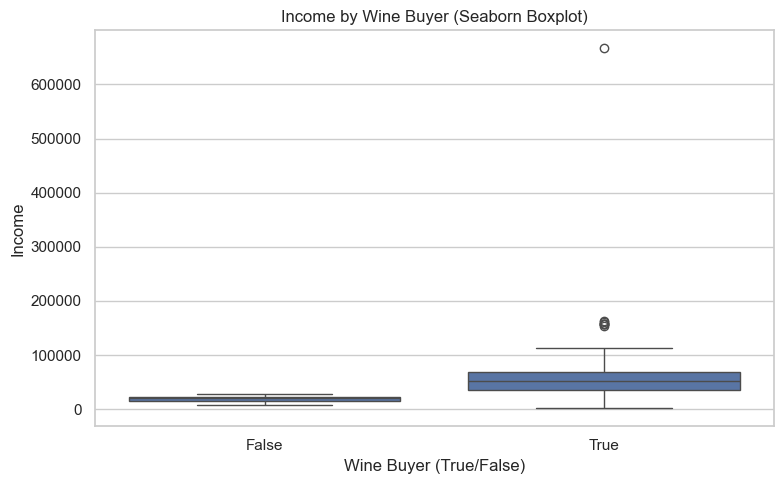

           count   median      mean
WineBuyer                          
False         13  20130.0  18167.46
True        2203  51537.0  52448.36
      WineBuyer   Income
0          True  58138.0
1          True  46344.0
2          True  71613.0
3          True  26646.0
4          True  58293.0
...         ...      ...
2235       True  61223.0
2236       True  64014.0
2237       True  56981.0
2238       True  69245.0
2239       True  52869.0

[2240 rows x 2 columns]


In [4]:

# Q1) Income vs wine purchasing
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(data=df[df['Income'].notna()], x='WineBuyer', y='Income', ax=ax)
ax.set_title('Income by Wine Buyer (Seaborn Boxplot)')
ax.set_xlabel('Wine Buyer (True/False)')
ax.set_ylabel('Income')
fig.tight_layout()
fig.savefig(outdir / 'q1_income_wine_seaborn.png', dpi=150)
plt.show()
plt.close(fig)

# KDE overlay
fig, ax = plt.subplots(figsize=(8,5))
for label, d in df[df['Income'].notna()].groupby('WineBuyer'):
    sns.kdeplot(d['Income'], ax=ax, label=f'WineBuyer={label}', fill=True, alpha=0.3)
ax.set_title('Income Distribution by Wine Buying')
ax.set_xlabel('Income')
ax.legend()
fig.tight_layout()
fig.savefig(outdir / 'q1_income_wine_kde.png', dpi=150)
plt.close(fig)

# Quick stats
stats_q1 = df.groupby('WineBuyer')['Income'].agg(['count','median','mean']).round(2)
print(stats_q1)
print(df[['WineBuyer','Income']])

